# Homework 7: scikit-image

Due Tuesday Apr 10, 6pm

## Counting objects

In class, we saw how to count the number of objects in a microscopy image.  Here, we will repeat that exercise, but make use of some of the algorithms in `scikit-image` to segment the image, and then to determine properties of the resulting objects.

As input, use the image `skimage.data.coins`.  Segment the image, and then calculate the area and eccentricity of each coin.

There are various ways to do this.  One would be:

1. Equalize the input image (see `skimage.exposure`)
2. Threshold the image (`skimage.filters.otsu`)
3. Remove objects touching the boundary (`skimage.segmentation.clear_border`)
4. Apply morphological closing (`skimage.morphology.closing`)
5. Remove small objects (`skimage.measure.regionprops`).
   Visualize the results if you want with `skimage.color.label2rgb`.
7. Calculate the area and eccentricity of each coin, and display the
   original image with this information on it (`matplotlib.pyplot.text` or `matplotlib.pyplot.annotate`)

In [1]:
import numpy as np
from skimage import exposure,filters,segmentation,morphology,measure,color,data,feature,draw
from skimage.measure import ransac, EllipseModel
%matplotlib inline
import matplotlib.pyplot as plt



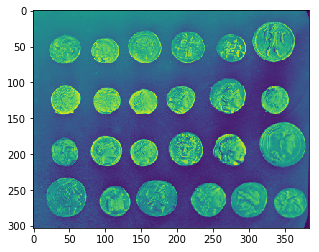

In [2]:
img = data.coins()
plt.imshow(img)


## Panorama stitching

One of the scikit-image tutorials shows [how to do panorama stitching](https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/solutions/adv3_panorama-stitching-solution.ipynb).

Take 3 or 4 overlapping photos of your own, and use the procedure described to stitch your own panorama.

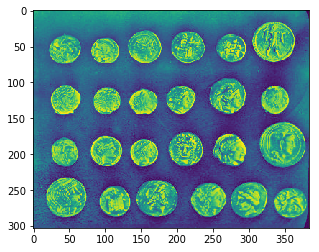

In [3]:
img_eq = exposure.equalize_adapthist(img)
plt.imshow(img_eq)

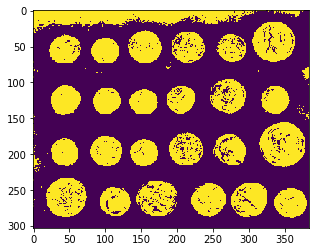

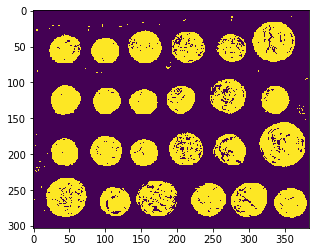

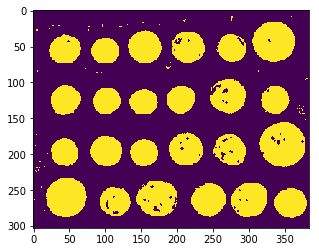

In [4]:
thresh = filters.threshold_otsu(img_eq)
mask = img_eq > thresh
img_no_border = segmentation.clear_border(mask)
img_open = morphology.closing(img_no_border)

img_closed = morphology.closing(img_open)
plt.figure()
plt.imshow(mask)
plt.figure()
plt.imshow(img_no_border)
plt.figure()
plt.imshow(img_closed)


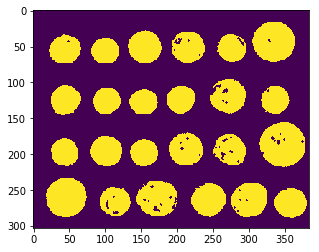

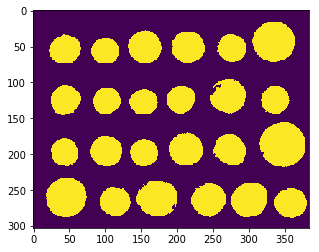

In [5]:
'''img_no_holes = morphology.remove_small_objects(img_no_border, 25)
plt.figure()
plt.imshow(img_no_holes)

structure_element = morphology.disk(1)

seed = np.copy(img_no_holes)
seed[1:-1, 1:-1] = img_no_holes.max()
mask = img_no_holes

img_filled = morphology.reconstruction(seed,mask,method='erosion',selem=structure_element)
plt.figure()
plt.imshow(img_filled)'''

img_no_holes = morphology.remove_small_objects(img_closed, 20)
plt.figure()
plt.imshow(img_no_holes)

structure_element = morphology.disk(1)

seed = np.copy(img_closed)
seed[1:-1, 1:-1] = img_no_holes.max()
mask = img_no_holes

img_filled = morphology.reconstruction(seed,mask,method='erosion',selem=structure_element)
plt.figure()
plt.imshow(img_filled)

[0.301608086582493, 0.2588273191016948, 0.32328214492665247, 0.4820362336863339, 0.3230932263914076, 0.4079476099818647, 0.3567648063696967, 0.34285975450318606, 0.38617931035972053, 0.22541717791035545, 0.33547631561012625, 0.4491120330619071, 0.2334570656518999, 0.2991290260944517, 0.4743215130978017, 0.265534506861356, 0.31790515286153387, 0.24573938723717487, 0.2662422831192836, 0.46746908971658135, 0.43351470853559887, 0.35518596889029425, 0.3390346289347694, 0.4210118968289985]
24


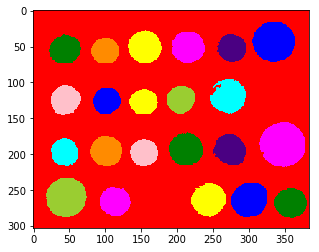

In [6]:
labels, num = measure.label(img_filled,return_num=True,connectivity=2)
label_img = color.label2rgb(labels)

plt.figure()
plt.imshow(label_img)
regions = measure.regionprops(labels)
areas = [r.area for r in regions]
ecc = [r.eccentricity for r in regions]

print(ecc)
print(num)

#img_edges = feature.canny(img_morph,sigma = .05)
#plt.imshow(img_edges)color.label2rgb(labels)

/Users/cwfink/anaconda3/envs/bootcamp-env/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


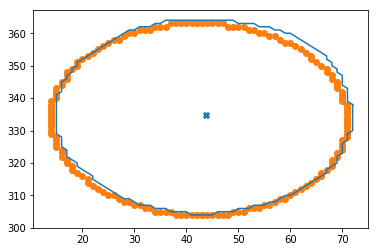

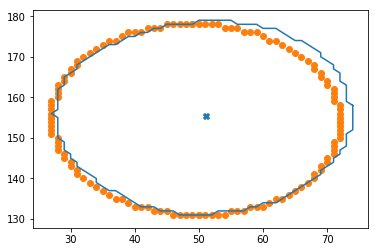

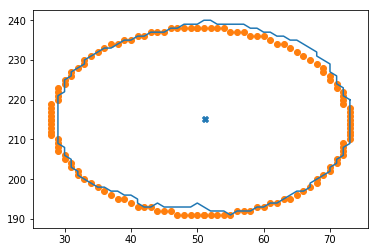

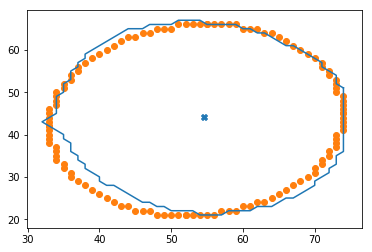

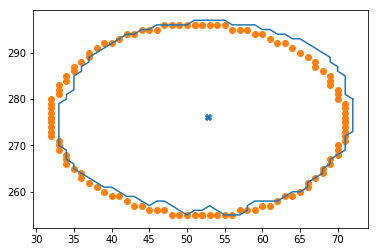

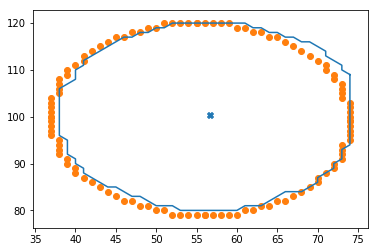

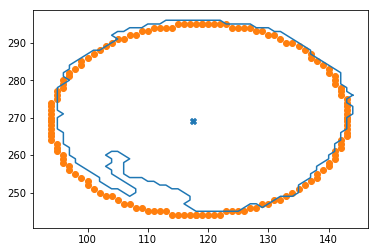

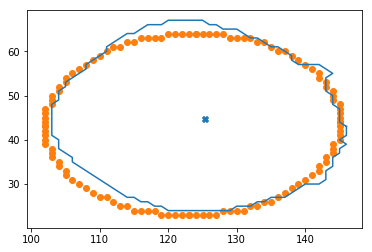

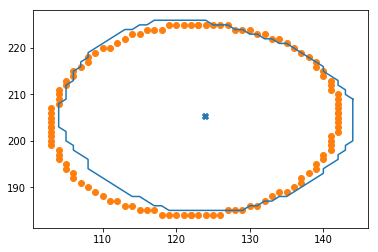

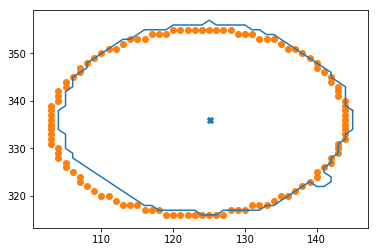

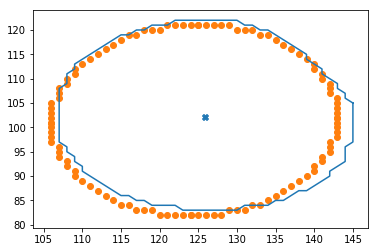

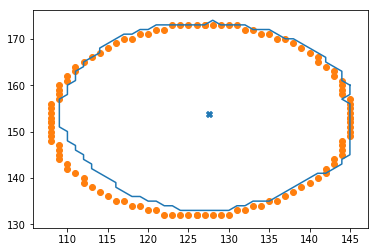

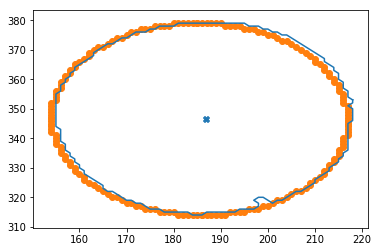

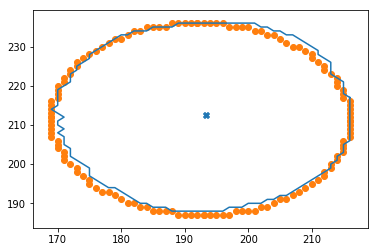

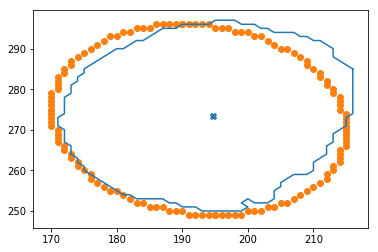

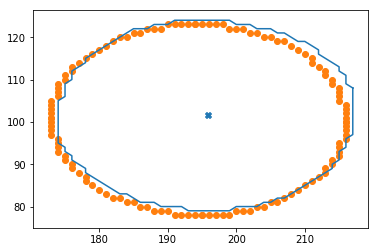

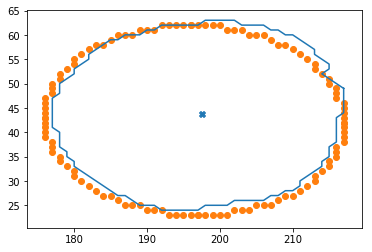

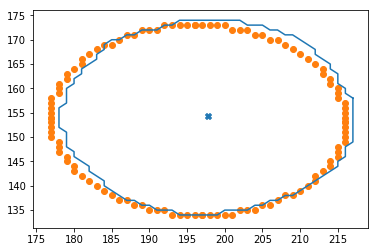

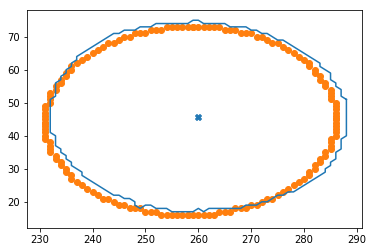

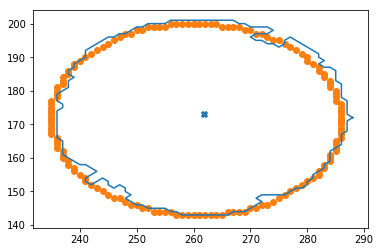

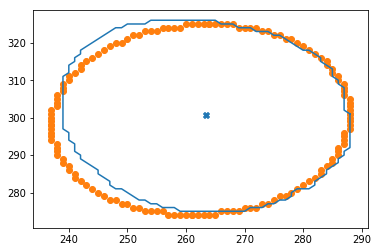

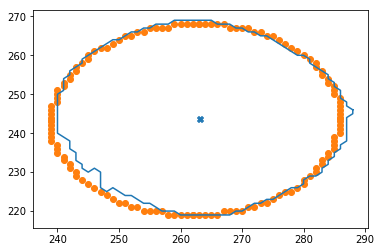

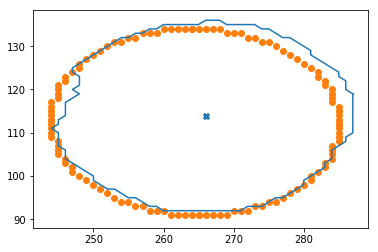

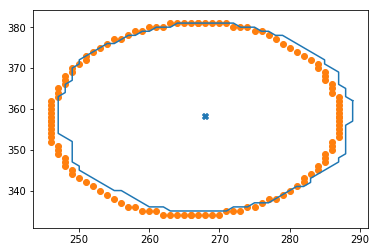

In [9]:
#edges = feature.canny(img_filled,sigma =.2)
edges = measure.find_contours(img_filled,level = 0)
x = np.ones(shape = len(edges))
y = np.ones(shape = len(edges))
coins = []
coin_properties = []


    
for coin in edges:

    model,inliers = ransac(coin, EllipseModel , min_samples=4,residual_threshold=2)
    xc, yc, a, b, theta = model.params
    ellipse = draw.ellipse_perimeter(int(xc), int(yc), int(a), int(b), theta)
    
    Area = np.pi*a*b
    if b < a:
        eccent = np.sqrt(1-(b/a)**2)
    elif b > a: 
        eccent = np.sqrt(1-(a/b)**2)
        
    x = coin[:,0]
    y = coin[:,1]
    center = [np.mean(x),np.mean(y)]
        
    data = {'location' : center,
            'Area' : Area,
            'eccentricity' : eccent,
            'ellipse' : ellipse}
    coin_properties.append(data)
    
    plt.figure()
    plt.plot(x,y)
    plt.scatter(center[0],center[1],marker='X')
    plt.scatter(ellipse[0],ellipse[1])
    





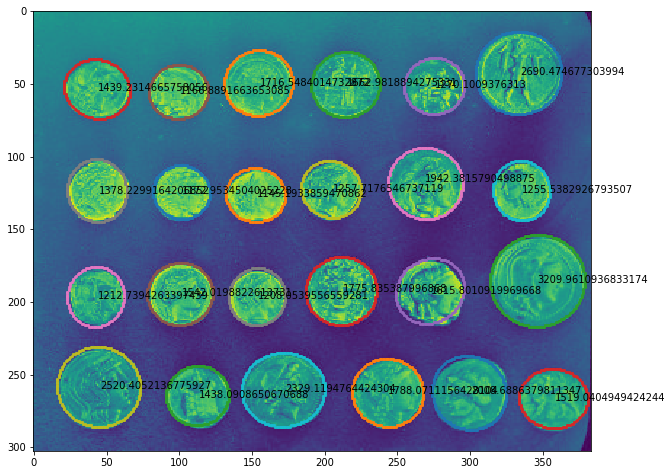

In [27]:
coin_properties[0]['ellipse']
plt.figure(figsize=(10,10))
plt.imshow(img)
for coin in coin_properties:
    x = coin['ellipse'][1]
    y = coin['ellipse'][0]
    
    plt.scatter(x,y,marker='X',s=4)
    plt.annotate(coin['Area'], xy = (0,0) , xytext = coin['location'][::-1])

## Extra: Image Stacking

Reprocess one of the datasets from http://www.rawastrodata.com/.  See http://www.rawastrodata.com/pages/typesofimages.html for a description of the different kind of images.